In [17]:
# 필요한 package들을 import 한다. 
import os
import sys
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# device 설정
# GPU를 사용할 수 있으면 사용하고, 아니면 CPU를 사용한다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory

In [18]:
# namedtuple은 key와 index를 통해 값에 접근할 수 있다.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


# ReplayMemory를 정의
class ReplayMemory(object):
    def __init__(self, capacity):
        # deque는 양방향 queue를 의미한다.
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        # Transition을 저장하는 부분이다.
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        # memory로부터 batch_size 길이 만큼의 list를 반환한다.
        return random.sample(self.memory, batch_size)

    def __len__(self):
        # memory의 길이를 반환한다.
        return len(self.memory)

# Network

In [19]:
class net(nn.Module):
    def __init__(self, action_size):
        super(net, self).__init__()
        self.fc1 = nn.Linear(4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
#         x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Agent

In [20]:
class DQNAgent:
    def __init__(self, action_size):
        self.render = False
        
        self.action_size = action_size
        
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01        
        self.train_start = 1000
        
        self.model = net(action_size).to(device)
        self.target_model = net(action_size).to(device)        
        self.optimizer = optim.Adam(self.model.parameters(), self.learning_rate)
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
        
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return torch.tensor([[random.randrange(self.action_size)]], device=device, \
        dtype=torch.long)
        else:
            return self.model(state).data.max(1)[1].view(1,1)
        
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        transitions = memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        next_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)
        
        
        predicts = self.model(state_batch).gather(1, action_batch)
        target_predicts = self.target_model(next_state_batch).detach()
                
        max_q = target_predicts.max(1)[0]
        targets = reward_batch + (~done_batch)*self.discount_factor*max_q            
        

    # Huber Loss 계산
        criterion = nn.SmoothL1Loss()
        loss = criterion(predicts, targets.unsqueeze(1)) # unsqueeze(): 차원 추가 

    # Optimize parameters
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.model.parameters():
            # 모든 원소를 [ min, max ]의 범위로 clamp
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        

# Main

In [21]:
env = gym.make('CartPole-v1')
action_size = env.action_space.n
memory = ReplayMemory(2000)

agent = DQNAgent(action_size)
scores, episodes = [], []
score_avg=0
HM_EPISODES = 300
BATCH_SIZE = 64

episode:   0 | score avg: 17.00 | steps: 17 | memory lengh:   17
episode:   1 | score avg: 17.10 | steps: 18 | memory lengh:   35
episode:   2 | score avg: 19.99 | steps: 46 | memory lengh:   81
episode:   3 | score avg: 21.99 | steps: 40 | memory lengh:  121
episode:   4 | score avg: 24.59 | steps: 48 | memory lengh:  169
episode:   5 | score avg: 24.13 | steps: 20 | memory lengh:  189
episode:   6 | score avg: 22.92 | steps: 12 | memory lengh:  201
episode:   7 | score avg: 22.43 | steps: 18 | memory lengh:  219
episode:   8 | score avg: 23.08 | steps: 29 | memory lengh:  248
episode:   9 | score avg: 22.18 | steps: 14 | memory lengh:  262
episode:  10 | score avg: 22.56 | steps: 26 | memory lengh:  288
episode:  11 | score avg: 22.60 | steps: 23 | memory lengh:  311
episode:  12 | score avg: 21.94 | steps: 16 | memory lengh:  327
episode:  13 | score avg: 21.65 | steps: 19 | memory lengh:  346
episode:  14 | score avg: 20.48 | steps: 10 | memory lengh:  356
episode:  15 | score avg:

episode: 126 | score avg: 209.43 | steps:231 | memory lengh: 2000
episode: 127 | score avg: 211.19 | steps:227 | memory lengh: 2000
episode: 128 | score avg: 212.47 | steps:224 | memory lengh: 2000
episode: 129 | score avg: 216.72 | steps:255 | memory lengh: 2000
episode: 130 | score avg: 217.35 | steps:223 | memory lengh: 2000
episode: 131 | score avg: 220.32 | steps:247 | memory lengh: 2000
episode: 132 | score avg: 223.08 | steps:248 | memory lengh: 2000
episode: 133 | score avg: 230.48 | steps:297 | memory lengh: 2000
episode: 134 | score avg: 230.93 | steps:235 | memory lengh: 2000
episode: 135 | score avg: 237.23 | steps:294 | memory lengh: 2000
episode: 136 | score avg: 234.31 | steps:208 | memory lengh: 2000
episode: 137 | score avg: 241.88 | steps:310 | memory lengh: 2000
episode: 138 | score avg: 267.69 | steps:500 | memory lengh: 2000
episode: 139 | score avg: 276.72 | steps:358 | memory lengh: 2000
episode: 140 | score avg: 296.55 | steps:475 | memory lengh: 2000
episode: 1

SystemExit: 

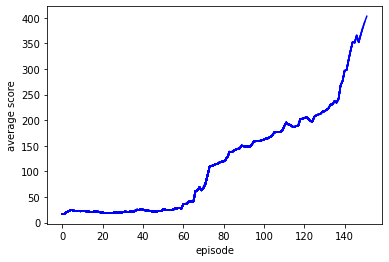

In [22]:
for episode in range(HM_EPISODES):    
    done = False
    score = 0
    steps = 0
    
    # env와 state 초기화
    state = env.reset()         # state shape >> torch.Size([1, 3, 40, 90]) 
    state = torch.tensor([state], device=device, dtype =torch.float) # state에 차원하나 추가 필요


    while not done:    
        
        if agent.render:
            env.render()
        
        action = agent.get_action(state)    # action result >> tensor([[0]]) or tensor([[1]])

        # 선택한 action을 대입하여 reward와 done을 얻어낸다. 
        # env.step(action.item())의 예시  
        # >> (array([-0.008956, -0.160571,  0.005936,  0.302326]), 1.0, False, {})
        next_state, reward, done, info = env.step(action.item())                
        score += reward
        reward = 0.1 if not done or score == 500 else -1
        
        reward = torch.tensor([reward], device=device, dtype = torch.float)
        next_state = torch.tensor([next_state], device=device, dtype =torch.float)                
        done = torch.tensor([done], device=device, dtype = torch.bool)

        # 얻어낸 transition set을 memory에 저장
        memory.push(state, action, next_state, reward, done)
        # (policy network에서) 최적화 한단계 수행
        
        if len(memory) >= agent.train_start:
            agent.train_model()

        # 다음 상태로 이동
        state = next_state
        steps += 1

        # 마찬가지로 done이 True 라면,
        if done:
            agent.update_target_model()
            score_avg = 0.9 * score_avg + 0.1 * score if score_avg !=0 else score
            print('episode: {:3d} | score avg: {:3.2f} | steps:{:3d} | memory lengh: {:4d}'.format(
                episode, score_avg, steps, len(memory)))
            scores.append(score_avg)
            episodes.append(episode)
            plt.plot(episodes, scores, 'b')
            plt.xlabel('episode')
            plt.ylabel('average score')
            
   
            if score_avg > 400:
                sys.exit()       
    

    
print('Complete')
scores.clear
episodes.clear

